<a id='Urbanization_Using_NDBI_top'></a>
# Urbanization Using NDBI
<hr>

## Background
Among the many urbanization indices, the Normalized Difference Built-Up Index (NDBI) is one of the most commonly used. This notebook shows how to use NDBI in the context of the Open Data Cube.

The formula for NDBI for Landsat is as follows:

$$ NDBI =  \frac{(SWIR - NIR)}{(SWIR + NIR)}$$  

Note that for arid environments, the Dry Built-Up Index (DBI) may perform better than NDBI, which struggles with arid environments and some kinds of buildings. DBI requires the TIR band of Landsat 8.

<br>

## Index

* [Import Dependencies and Connect to the Data Cube](#Urbanization_Using_NDBI_import)
* [Choose Platform and Product](#Urbanization_Using_NDBI_plat_prod)
* [Define the Extents of the Analysis](#Urbanization_Using_NDBI_define_extents)
* [Load Data from the Data Cube](#Urbanization_Using_NDBI_retrieve_data)
* [Show RGB Representation of the Area](#Urbanization_Using_NDBI_rgb)
* [Urbanization Analysis](#Urbanization_Using_NDBI_analysis)

## <span id="Urbanization_Using_NDBI_import">Import Dependencies and Connect to the Data Cube [&#9652;](#Urbanization_Using_NDBI_top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import matplotlib.pyplot as plt
import xarray as xr

from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_rgb import rgb

from utils.data_cube_utilities.urbanization import NDBI
from utils.data_cube_utilities.vegetation import NDVI
from utils.data_cube_utilities.dc_water_classifier import NDWI

import datacube
dc = datacube.Datacube()

## <span id="Urbanization_Using_NDBI_plat_prod">Choose Platform and Product [&#9652;](#Urbanization_Using_NDBI_top)</span>

In [2]:
# Get available products
products_info = dc.list_products()

In [3]:
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [4]:
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose the platforms and products**

In [5]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.

platform = 'LANDSAT_8'
product = 'ls8_lasrc_ghana'

## <span id="Urbanization_Using_NDBI_define_extents">Define the Extents of the Analysis [&#9652;](#Urbanization_Using_NDBI_top)</span>

In [6]:
# Kumasi, Ghana
# lat = (6.597724,6.781856)
# lon = (-1.727843,-1.509147)

# Accra, Ghana
lat = (5.5162, 5.6338)
lon = (-0.2657, -0.1373)

time_range = ("2019-01-01", "2019-12-31")

**Visualize the selected area**

In [7]:
display_map(lat, lon)

## <span id="Urbanization_Using_NDBI_retrieve_data">Load Data from the Data Cube [&#9652;](#Urbanization_Using_NDBI_top)</span>

In [8]:
desired_bands = ['red','green','nir','swir1', 'swir2', 'pixel_qa']  # needed by ndvi, ndwi, ndbi and cloud masking
desired_bands = desired_bands + ['blue'] # blue is needed for a true color visualization purposes

landsat_ds = dc.load(product = product,
                     platform = platform,
                     lat = lat,
                     lon = lon,
                     time = time_range,
                     measurements = desired_bands)

In [9]:
clean_mask = (landsat_qa_clean_mask(landsat_ds, platform) & 
              (landsat_ds != -9999).to_array().all('variable') & 
              landsat_clean_mask_invalid(landsat_ds))

In [10]:
landsat_ds = landsat_ds.where(clean_mask)

## <span id="Urbanization_Using_NDBI_rgb">Show RGB Representation of the Area [&#9652;](#Urbanization_Using_NDBI_top)</span>

In [11]:
median_composite = landsat_ds.median('time')

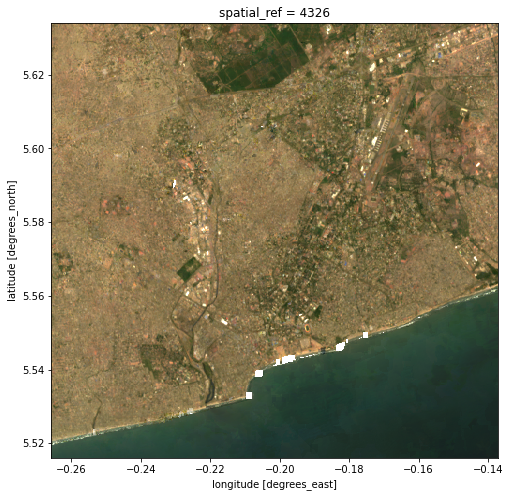

In [12]:
plt.figure(figsize=(8,8))
median_composite[['red', 'green', 'blue']].to_array().plot.imshow(vmin=0, vmax=2500)
plt.show()

## <span id="Urbanization_Using_NDBI_analysis">Urbanization Analysis [&#9652;](#Urbanization_Using_NDBI_top)</span>

> **NDWI, NDVI, NDBI**  
You will very rarely have urban classification and water classifications apply to the same pixel. For urban analysis, it may make sense to compute not just urban classes, but classes that are unlikely to co-occur with urbanization, such as vegetation (e.g. NDVI) or water (e.g. NDWI).

In [13]:
ndbi = NDBI(median_composite) # Urbanization
ndvi = NDVI(median_composite) # Dense Vegetation
ndwi = NDWI(median_composite) # High Concentrations of Water

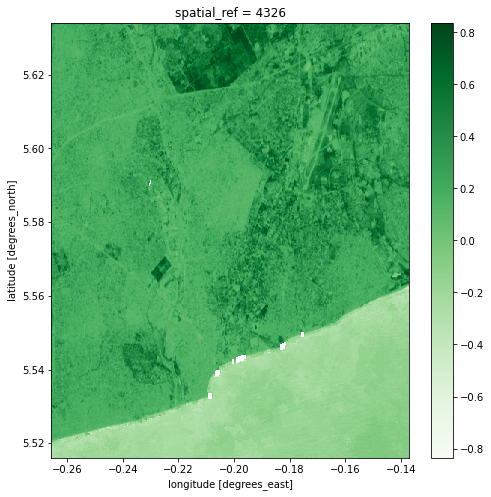

In [14]:
plt.figure(figsize=(8,8))
ndvi.plot(cmap = "Greens")
plt.show()

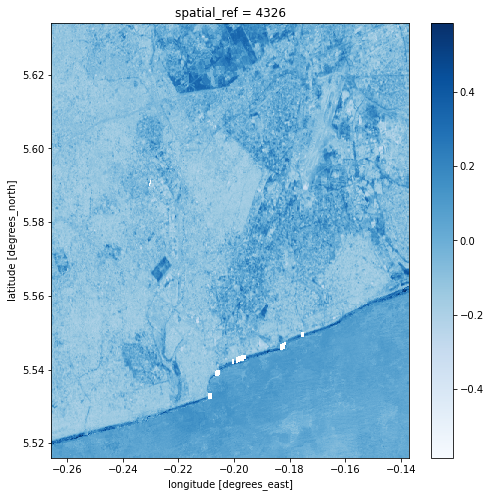

In [15]:
plt.figure(figsize=(8,8))
ndwi.plot(cmap = "Blues")
plt.show()

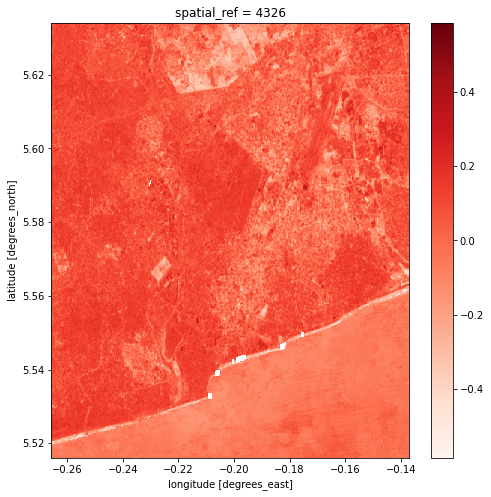

In [16]:
plt.figure(figsize=(8,8))
ndbi.plot(cmap = "Reds")
plt.show()

> **Merge into one Dataset**  
> If your data-arrays share the same set of coordinates, and you feel that you'll be using these values together in the future, you should consider merging them into an `xarray.Dataset`.

In [17]:
urbanization_dataset = xr.merge((ndvi.rename('NDVI'), ndwi.rename('NDWI'), ndbi.rename('NDBI')))

In [18]:
urbanization_dataset

<xarray.Dataset>
Dimensions:      (latitude: 438, longitude: 477)
Coordinates:
  * latitude     (latitude) float64 5.634 5.634 5.633 ... 5.517 5.516 5.516
  * longitude    (longitude) float64 -0.2656 -0.2653 -0.265 ... -0.1376 -0.1373
    spatial_ref  int32 4326
Data variables:
    NDVI         (latitude, longitude) float64 0.2379 0.2784 ... -0.0623
    NDWI         (latitude, longitude) float64 -0.07809 -0.037 ... 0.01418
    NDBI         (latitude, longitude) float64 0.07809 0.037 ... -0.01418

>**Building a False Color Composite**  
> If you have three lowly correlated measurements, place the measurement on red, green, and blue channels and visualize them. 

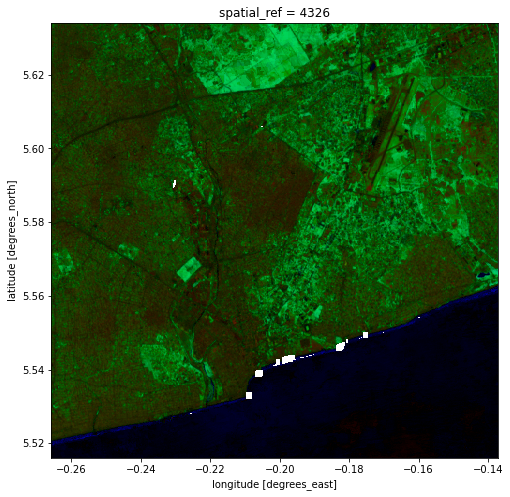

In [19]:
plt.figure(figsize=(8,8))
urbanization_dataset[["NDBI", "NDVI", "NDWI"]].to_array().plot.imshow(vmin=0, vmax=1)
plt.show()

<!-- ![](diagrams/urbanization/false_color.png) -->

>**Analyze The False Color Image**  
> Values that adhere strongly to individual classes adhere to their own color channel. In this example, NDVI adheres to green, NDWI adheres to blue, and NDBI adheres to red.  

> **Validate urbanization using other imagery**  
> Double check results using high-resolution imagery.  Compare to the false color mosaic
<br>

In [20]:
display_map(latitude = lat ,longitude = lon)  